In [1]:
# 라이브러리 호출
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Saving catanddog.zip to catanddog.zip


In [3]:
!unzip catanddog.zip -d catanddog/  #catanddog 폴더 만들어 압축 풀기

Archive:  catanddog.zip
   creating: catanddog/test/
   creating: catanddog/test/Cat/
  inflating: catanddog/test/Cat/8100.jpg  
  inflating: catanddog/test/Cat/8101.jpg  
  inflating: catanddog/test/Cat/8102.jpg  
  inflating: catanddog/test/Cat/8103.jpg  
  inflating: catanddog/test/Cat/8104.jpg  
  inflating: catanddog/test/Cat/8105.jpg  
  inflating: catanddog/test/Cat/8106.jpg  
  inflating: catanddog/test/Cat/8107.jpg  
  inflating: catanddog/test/Cat/8108.jpg  
  inflating: catanddog/test/Cat/8109.jpg  
  inflating: catanddog/test/Cat/8110.jpg  
  inflating: catanddog/test/Cat/8111.jpg  
  inflating: catanddog/test/Cat/8112.jpg  
  inflating: catanddog/test/Cat/8113.jpg  
  inflating: catanddog/test/Cat/8114.jpg  
  inflating: catanddog/test/Cat/8115.jpg  
  inflating: catanddog/test/Cat/8116.jpg  
  inflating: catanddog/test/Cat/8117.jpg  
  inflating: catanddog/test/Cat/8118.jpg  
  inflating: catanddog/test/Cat/8119.jpg  
  inflating: catanddog/test/Cat/8120.jpg  
  inflating

In [4]:
# 이미지 데이터 전처리 방법 정의
data_path = 'catanddog/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


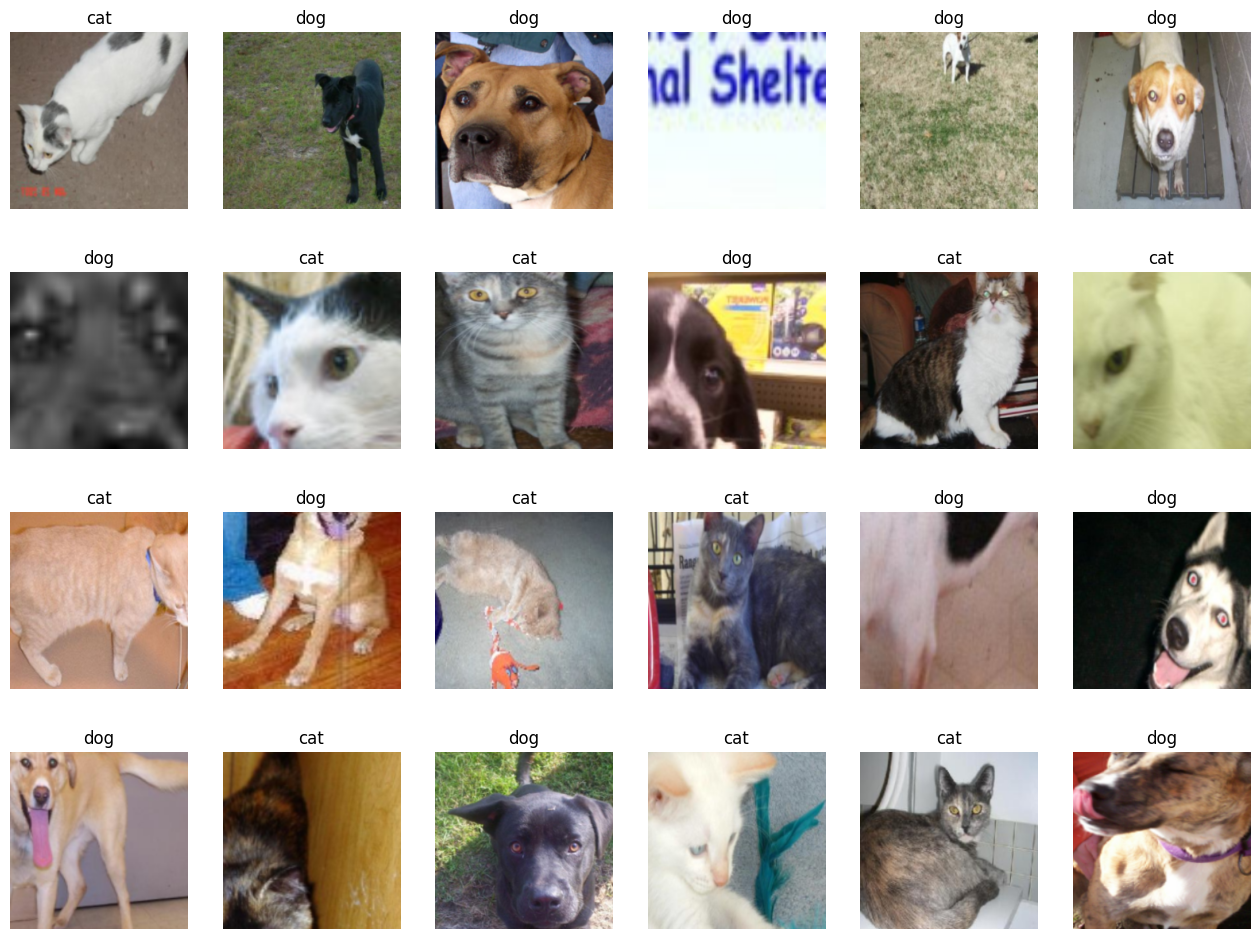

In [5]:
# 학습에 사용될 이미지 출력
import numpy as np
samples, labels = next(iter(train_loader)) ####
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
# 사전 훈련된 모델 내려 받기
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


In [7]:
# 사전 훈련된 모델 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [8]:
# ResNet18에 완전 연결층 추가
resnet18.fc = nn.Linear(512, 2)

In [9]:
# 모델 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0201, -0.0411,  0.0051,  ...,  0.0004,  0.0276, -0.0091],
        [ 0.0316, -0.0427,  0.0232,  ...,  0.0169,  0.0003, -0.0305]])
fc.bias tensor([ 0.0167, -0.0430])


In [10]:
# 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=40, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [13]:
# 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [14]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/39
----------
Loss: 0.5690 Acc: 0.6987

Epoch 1/39
----------
Loss: 0.3783 Acc: 0.8571

Epoch 2/39
----------
Loss: 0.3019 Acc: 0.9091

Epoch 3/39
----------
Loss: 0.2757 Acc: 0.8987

Epoch 4/39
----------
Loss: 0.2698 Acc: 0.9091

Epoch 5/39
----------
Loss: 0.2607 Acc: 0.8805

Epoch 6/39
----------
Loss: 0.2039 Acc: 0.9351

Epoch 7/39
----------
Loss: 0.2269 Acc: 0.9039

Epoch 8/39
----------
Loss: 0.2024 Acc: 0.9221

Epoch 9/39
----------
Loss: 0.1907 Acc: 0.9273

Epoch 10/39
----------
Loss: 0.2106 Acc: 0.9221

Epoch 11/39
----------
Loss: 0.2536 Acc: 0.8935

Epoch 12/39
----------
Loss: 0.2154 Acc: 0.8961

Epoch 13/39
----------
Loss: 0.1906 Acc: 0.9195

Epoch 14/39
----------
Loss: 0.2007 Acc: 0.9221

Epoch 15/39
----------
Loss: 0.1696 Acc: 0.9299

Epoch 16/39
----------
Loss: 0.2326 Acc: 0.9065

Epoch 17/39
----------
Loss: 0.2434 Acc: 0.8935

Epoch 18/39
----------
Loss: 0.1894 Acc: 0.9169

Epoch 19/39
----------
Loss: 0.2136 Acc: 0.9091

Epoch 20/39
----------
Loss: 0

In [15]:
# 테스트 데이터 호출 및 전처리
test_path = 'catanddog/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))


98


In [16]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [17]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth', 'catanddog/13.pth', 'catanddog/14.pth', 'catanddog/15.pth', 'catanddog/16.pth', 'catanddog/17.pth', 'catanddog/18.pth', 'catanddog/19.pth', 'catanddog/20.pth', 'catanddog/21.pth', 'catanddog/22.pth', 'catanddog/23.pth', 'catanddog/24.pth', 'catanddog/25.pth', 'catanddog/26.pth', 'catanddog/27.pth', 'catanddog/28.pth', 'catanddog/29.pth', 'catanddog/30.pth', 'catanddog/31.pth', 'catanddog/32.pth', 'catanddog/33.pth', 'catanddog/34.pth', 'catanddog/35.pth', 'catanddog/36.pth', 'catanddog/37.pth', 'catanddog/38.pth', 'catanddog/39.pth']
Loading model catanddog/00.pth
Acc: 0.8776

Loading model catanddog/01.pth
Acc: 0.9286

Loading model catanddog/02.pth
Acc: 0.9184

Loading model catanddog/03.pth
Acc: 0.9490

Loading mod

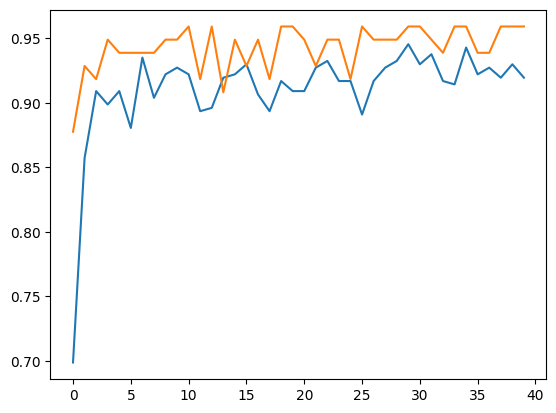

In [18]:
# 훈련 데이터와 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

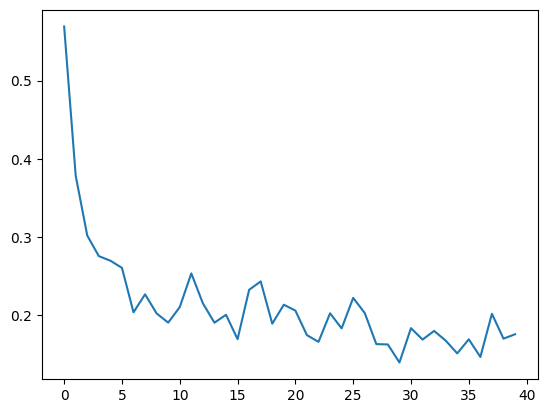

In [19]:
# 훈련 데이터 오차 그림 확인
plt.plot(train_loss_hist)
plt.show()

In [20]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

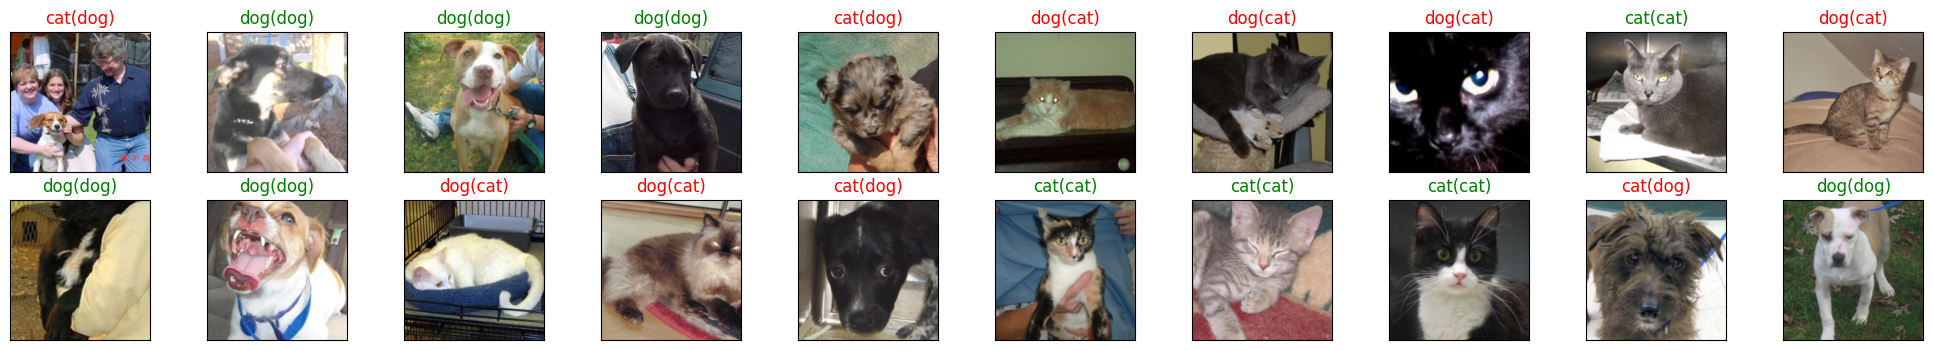

<Figure size 640x480 with 0 Axes>

In [21]:
# 개와 고양이 예측 결과 출력
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)
images,labels=next(dataiter)
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [22]:
# 모델 저장
torch.save(model, 'model.pt')

In [28]:
import cv2
from torchvision.transforms import ToTensor

In [47]:
from google.colab import files
file_uploaded=files.upload()

Saving mango3.jpg to mango3.jpg


In [48]:
model2 = torch.load('model.pt')

(-0.5, 2047.5, 1535.5, -0.5)

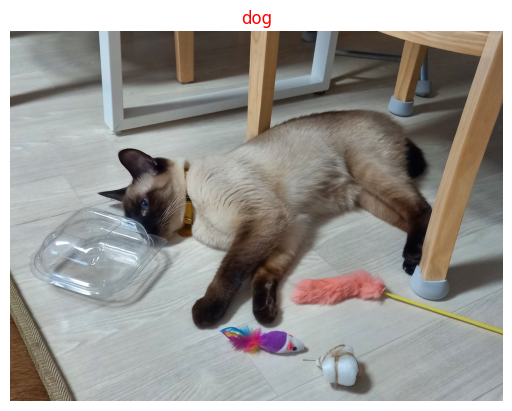

In [49]:
img = cv2.imread("mango3.jpg",cv2.IMREAD_COLOR)
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = ToTensor()(img).unsqueeze(0)
model2 = torch.load('model.pt')
output = model2(img)

classes = {0:'cat', 1:'dog'}
_,preds=torch.max(output,1)
title = classes[preds.item()]

plt.imshow(image)
plt.title(title, color=("green" if title=='cat' else "red"))
plt.axis('off')

In [46]:
print(output)

tensor([[0.1361, 0.3183]], grad_fn=<AddmmBackward0>)
